In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy import signal

from shapely.geometry import Point

## Emplacement des stations

In [3]:
tableau_stations_file = "../Data/Seine/Stations_2019.csv"
tableau_stations = gpd.read_file(tableau_stations_file, encoding="UTF-8")
n_stations = tableau_stations.shape[0]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [4]:
tableau_stations['geometry'] = tableau_stations.apply(lambda x: Point(float(x['X (m)']), float(x['Y (m)'])), axis = 1)
tableau_stations = tableau_stations.set_crs('EPSG:27572')
tableau_stations = tableau_stations.to_crs(world.crs)
tableau_stations

,Code station,Libelle station,Regime influencé,Altitude du zéro de l'échelle,Coordonnées,X (m),Y (m),geometry
0,H0020010,La Seine à Quemigny-sur-Seine [Cosne],pas ou faiblement,288.05,Lambert II Étendu,775157,2300217,POINT (4.66954 47.67808)
1,H0100010,La Seine à Nod-sur-Seine,pas ou faiblement,248.25,Lambert II Étendu,767439,2309604,POINT (4.57034 47.76448)
2,H0100020,La Seine à Plaines-Saint-Lange,pas ou faiblement,179.35,Lambert II Étendu,760029,2335130,POINT (4.48082 47.99581)
3,H0400010,La Seine à Bar-sur-Seine,pas ou faiblement,148,Lambert II Étendu,751916,2348365,POINT (4.37676 48.11672)
4,H0400020,La Seine à Courtenot,pas ou faiblement,0,Lambert II Étendu,746950,2351620,POINT (4.31119 48.14712)
5,H0800011,La Seine [partielle] à Troyes [Foicy],fortement,102,Lambert II Étendu,731065,2368493,POINT (4.10290 48.30219)
6,H0800012,La Seine [partielle] à Troyes [Tauxelles],fortement,100,Lambert II Étendu,729271,2369769,POINT (4.07911 48.31402)
7,H0810010,La Seine à Méry-sur-Seine [après création gran...,fortement,78,Lambert II Étendu,714764,2390999,POINT (3.88926 48.50758)
8,H1700010,La Seine à Pont-sur-Seine,fortement,60,Lambert II Étendu,692920,2392352,POINT (3.59406 48.52325)
9,H1940020,La Seine à Bazoches-lès-Bray [station ultrason],fortement,52.59,Lambert II Étendu,663190,2381000,POINT (3.19008 48.42479)


In [5]:
world[world['name'] == "France"]

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
43,67106161,Europe,France,-99,2699000.0,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3..."


C:\Users\44493\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  """Entry point for launching an IPython kernel.


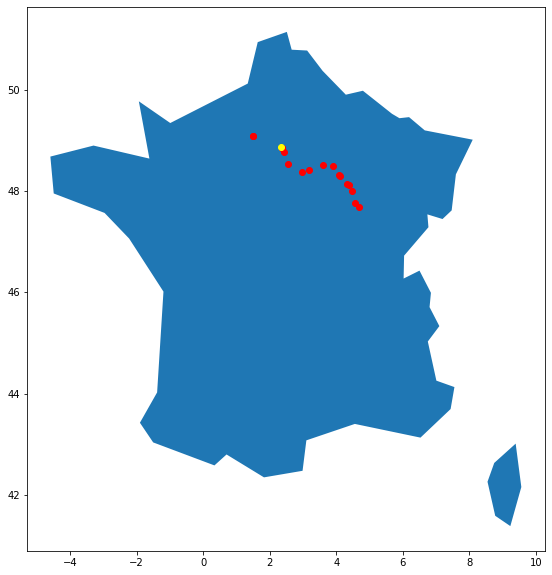

In [6]:
france = world[world['name'] == "France"].geometry.explode()[[1,2]].unary_union

base = gpd.GeoSeries(france).plot(figsize = (10, 10))
tableau_stations.plot(ax = base, color = "red")
cities[cities['name'] == "Paris"].plot(ax = base, color = "yellow")

On trie les stations d'Est en Ouest et du Sud au Nord.

In [7]:
tableau_stations["Ord"] = tableau_stations["geometry"].apply(lambda x: x.coords[:][0][1])
tableau_stations["Abs"] = tableau_stations["geometry"].apply(lambda x: x.coords[:][0][0])

tri = tableau_stations.sort_values(by = "Ord", ascending=True).sort_values(by = "Abs", ascending=False)[["Code station"]]
for i in range(n_stations):
    code = tri["Code station"][i]
    tableau_stations.loc[tableau_stations["Code station"] == code,"Ordre"] = i

station_amont_pt = tableau_stations["geometry"].to_crs("EPSG:32633")[tableau_stations["Ordre"].values.argmin()]
tableau_stations["Distance amont"] = tableau_stations["geometry"].to_crs("EPSG:32633").distance(station_amont_pt)
tableau_stations

,Code station,Libelle station,Regime influencé,Altitude du zéro de l'échelle,Coordonnées,X (m),Y (m),geometry,Ord,Abs,Ordre,Distance amont
0,H0020010,La Seine à Quemigny-sur-Seine [Cosne],pas ou faiblement,288.05,Lambert II Étendu,775157,2300217,POINT (4.66954 47.67808),47.678077,4.669536,0.0,0.000000
1,H0100010,La Seine à Nod-sur-Seine,pas ou faiblement,248.25,Lambert II Étendu,767439,2309604,POINT (4.57034 47.76448),47.764483,4.570344,1.0,12237.974218
2,H0100020,La Seine à Plaines-Saint-Lange,pas ou faiblement,179.35,Lambert II Étendu,760029,2335130,POINT (4.48082 47.99581),47.995810,4.480821,2.0,38317.012655
3,H0400010,La Seine à Bar-sur-Seine,pas ou faiblement,148,Lambert II Étendu,751916,2348365,POINT (4.37676 48.11672),48.116723,4.376762,3.0,53841.366447
4,H0400020,La Seine à Courtenot,pas ou faiblement,0,Lambert II Étendu,746950,2351620,POINT (4.31119 48.14712),48.147122,4.311194,4.0,59049.921864
5,H0800011,La Seine [partielle] à Troyes [Foicy],fortement,102,Lambert II Étendu,731065,2368493,POINT (4.10290 48.30219),48.302190,4.102904,5.0,81860.463065
6,H0800012,La Seine [partielle] à Troyes [Tauxelles],fortement,100,Lambert II Étendu,729271,2369769,POINT (4.07911 48.31402),48.314019,4.079115,6.0,83925.435841
7,H0810010,La Seine à Méry-sur-Seine [après création gran...,fortement,78,Lambert II Étendu,714764,2390999,POINT (3.88926 48.50758),48.507577,3.889262,7.0,109828.571470
8,H1700010,La Seine à Pont-sur-Seine,fortement,60,Lambert II Étendu,692920,2392352,POINT (3.59406 48.52325),48.523246,3.594062,8.0,124422.734573
9,H1940020,La Seine à Bazoches-lès-Bray [station ultrason],fortement,52.59,Lambert II Étendu,663190,2381000,POINT (3.19008 48.42479),48.424787,3.190077,9.0,139148.032761


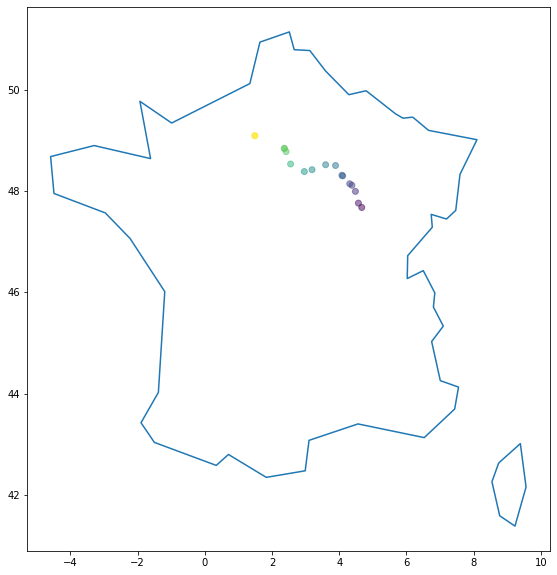

In [35]:
# On a 17 stations
base = gpd.GeoSeries(france).boundary.plot(figsize = (10, 10))
dist_aval = tableau_stations["Distance amont"].values.max()
tableau_stations.plot(ax = base, color = cm.get_cmap("viridis")(tableau_stations["Distance amont"]/dist_aval), alpha = 0.5)

## Explorations

In [36]:
# Initialisation
mesures = pd.read_csv("../Data/Seine/" + tableau_stations["Code station"][0] + "_2019.csv",
                      sep = ";")[["Date"]]

for i in range(n_stations):
    code = tableau_stations[tableau_stations["Ordre"] == i]["Code station"].values[0]
    station = pd.read_csv("../Data/Seine/" + code + "_2019.csv",
                      sep = ";")
    station = station.rename(columns = {"Q (m3/s)": code})
    mesures = mesures.merge(station[["Date", code]],
                           on = "Date",
                           how = "outer")
    
mesures["Date"] = pd.to_datetime(mesures["Date"], format = "%d/%m/%Y %H:%M")
mesures = mesures.sort_values(by = "Date")

mesures.to_csv("../Data/Seine/Mesures_2019.csv")

mesures.head()

,Date,H0020010,H0100010,H0100020,H0400010,H0400020,H0800011,H0800012,H0810010,H1700010,H1940020,H2900011,H3930020,H4340020,H5920011,H5920014,H8100020,H8100021
0,2019-01-01 00:00:00,3.22,4.66,13.9,30.1,10.9,3.02,17.0,17.1,43.6,36.9,NaN,144.0,150.0,138.0,261.0,NaN,429.0
1,2019-01-01 02:00:00,3.20,4.60,13.8,29.8,11.5,3.03,16.8,17.1,43.5,38.3,NaN,147.0,158.0,133.0,251.0,NaN,354.0
2,2019-01-01 04:00:00,3.15,4.57,13.7,29.6,11.4,3.04,16.7,17.2,43.3,40.1,NaN,161.0,157.0,126.0,247.0,NaN,308.0
3,2019-01-01 06:00:00,3.11,4.54,13.5,29.3,11.2,3.04,16.5,17.3,43.1,40.2,NaN,163.0,161.0,118.0,245.0,NaN,304.0
4,2019-01-01 08:00:00,3.08,4.48,13.4,29.1,11.1,3.04,16.5,17.3,43.1,38.9,NaN,148.0,167.0,114.0,240.0,NaN,308.0


In [37]:
mesures.describe(include = "all")

,Date,H0020010,H0100010,H0100020,H0400010,H0400020,H0800011,H0800012,H0810010,H1700010,H1940020,H2900011,H3930020,H4340020,H5920011,H5920014,H8100020,H8100021
count,4380,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4007.000000,4380.000000,4380.000000,3676.000000,4380.000000,770.000000,4379.000000
unique,4380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2019-07-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.266792,3.110822,8.040532,18.409879,10.266619,8.711340,14.468632,22.245114,48.492534,41.830187,117.508186,145.500457,156.277329,227.717519,245.017169,537.844156,359.080110
std,NaN,3.048225,4.216932,8.007153,21.390395,9.877947,11.555978,4.979339,13.700793,27.023177,27.481360,87.638521,105.708836,111.001536,113.491777,174.544430,338.878582,237.471412
min,NaN,0.160000,0.200000,1.560000,2.130000,1.720000,1.810000,6.890000,11.400000,23.900000,9.340000,35.100000,41.300000,32.900000,99.600000,71.900000,169.000000,27.700000
25%,NaN,0.310000,0.400000,2.220000,3.020000,3.270000,2.567500,11.000000,15.200000,33.900000,25.300000,58.500000,70.300000,74.275000,158.000000,116.000000,294.000000,182.000000


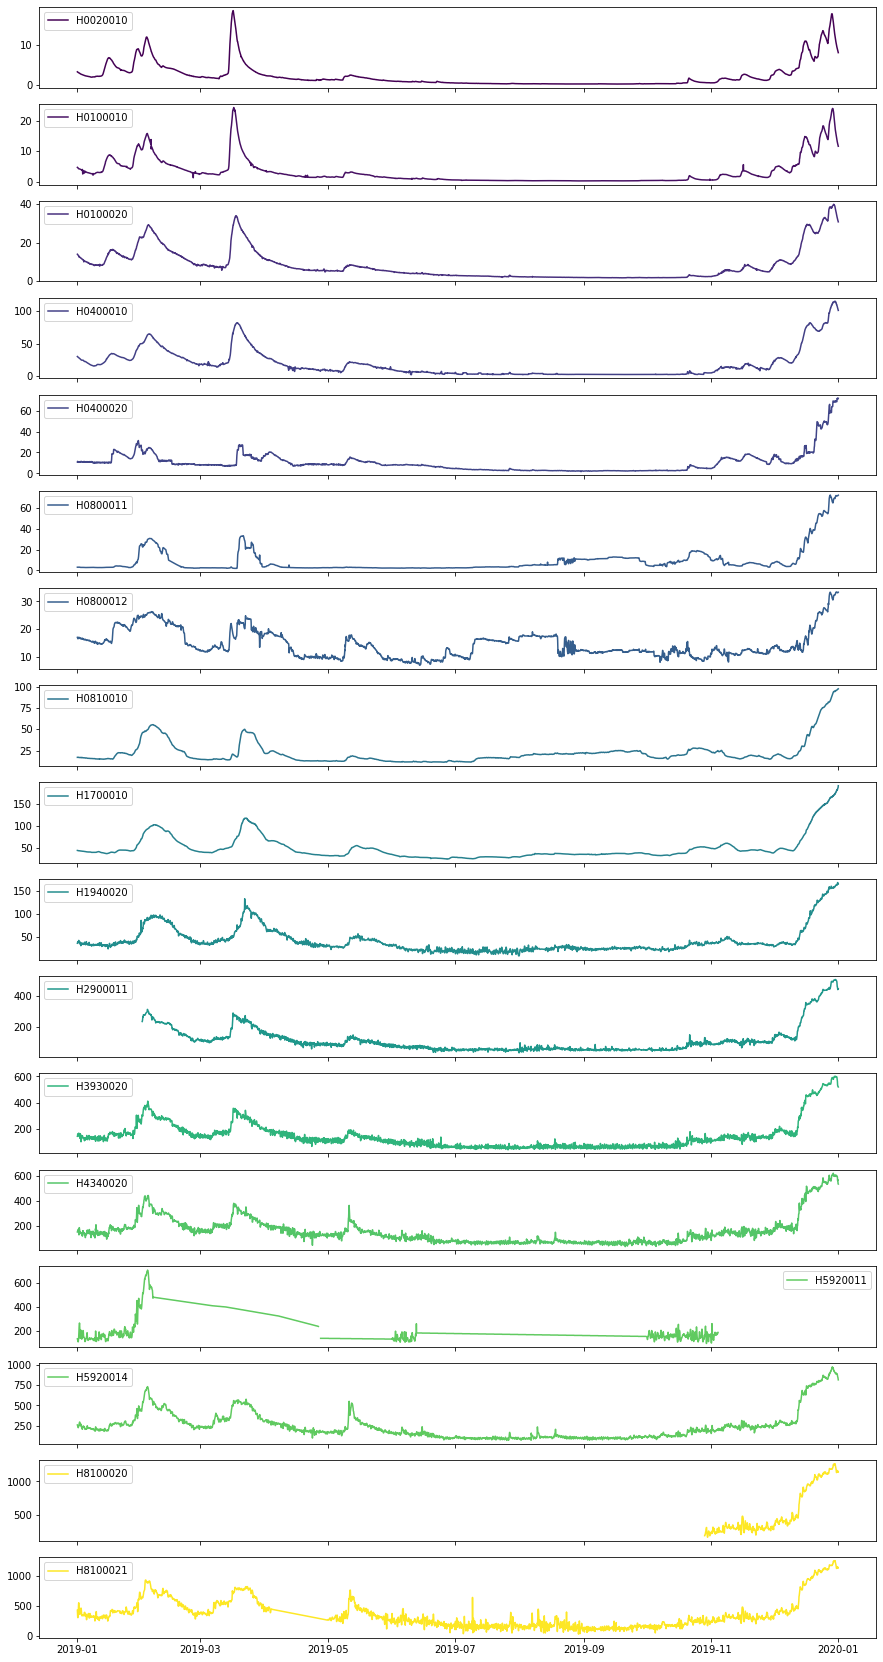

In [38]:
fig, axs = plt.subplots(n_stations, 1, figsize = (15,30), sharex=True)
for i in range(n_stations):
    code = tableau_stations[tableau_stations["Ordre"] == i]["Code station"].values[0]
    axs[i].plot(mesures["Date"], mesures[code], label = code, 
                color = cm.get_cmap("viridis")(tableau_stations.loc[i, "Distance amont"]/dist_aval))
    axs[i].legend()

In [39]:
# mesures.corr()

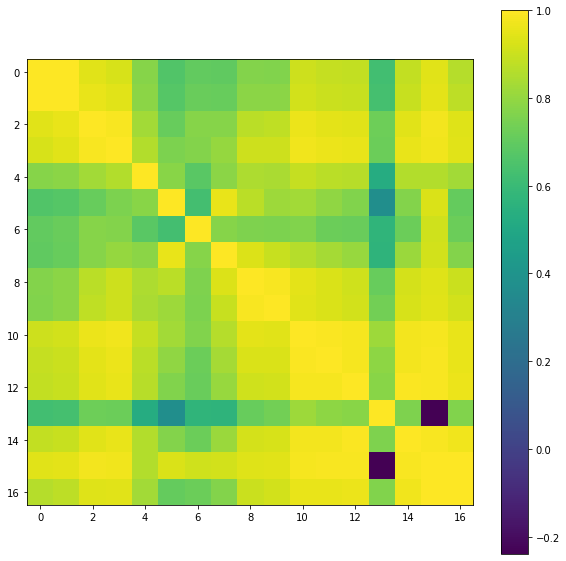

In [40]:
fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(mesures.corr())
fig.colorbar(im)

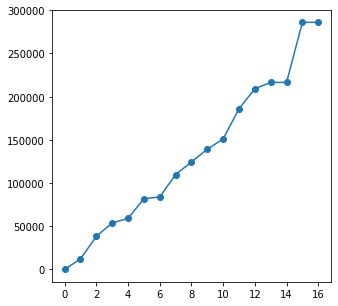

In [41]:
# Voir la répartition les distances
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(tableau_stations["Ordre"], 
        tableau_stations["Distance amont"],
       marker = "o")

## Corrélations croisées

On prend la station amont, une station au milieu (au pif, la numéro 8) et la 16 et on regarde les corrélations croisées.

In [42]:
stations_corr = [tableau_stations[tableau_stations["Ordre"] == 0]["Code station"].values[0],
                 tableau_stations[tableau_stations["Ordre"] == int((n_stations-1)/2)]["Code station"].values[0],
                 tableau_stations[tableau_stations["Ordre"] == n_stations-3]["Code station"].values[0]]
mesures_corr = pd.DataFrame()
mesures_crosscorr = pd.DataFrame()
origine = len(mesures)-1
max_lag = 12*30

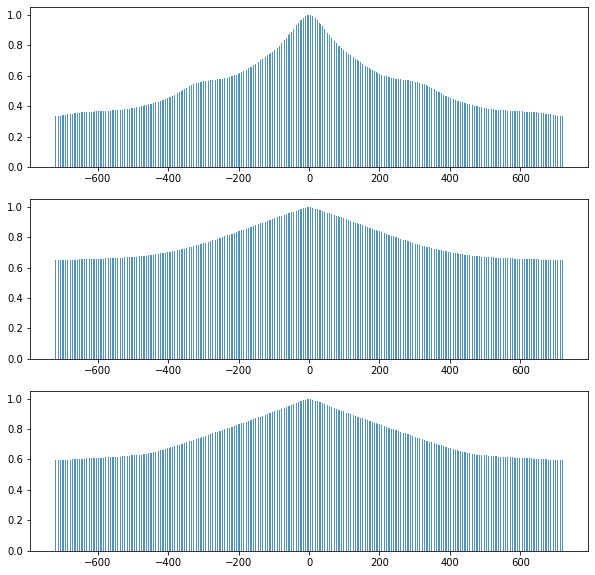

In [43]:
fig, axs = plt.subplots(3, 1, figsize = (10,10))

for i in range(3):
    current_station = stations_corr[i]
    corr= signal.correlate(mesures[current_station], mesures[current_station], mode = "full")
    corr /= np.max(corr)
    mesures_corr[current_station]=corr
    axs[i].bar([2*i for i in range(-max_lag, max_lag+1)],
               corr[(origine-max_lag):(origine+max_lag+1)],
              alpha = 0.8,
               width = 1.,
              log = False)

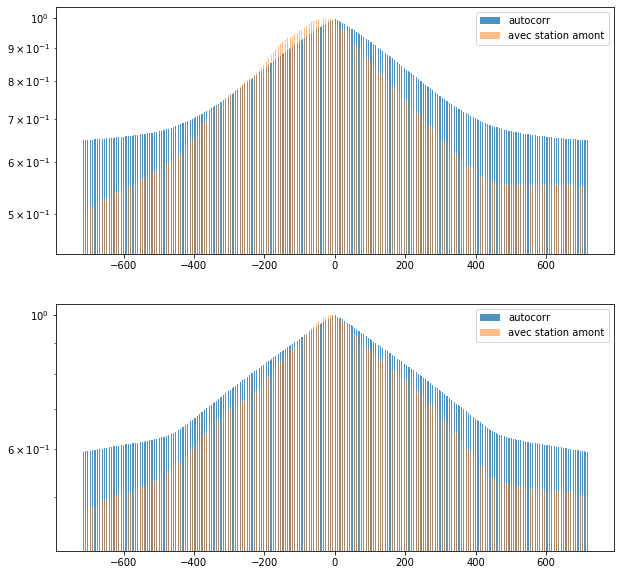

In [44]:
fig, axs = plt.subplots(2, 1, figsize = (10,10))
station_amont = tableau_stations["Code station"][tableau_stations["Ordre"].values.argmin()]

for i in range(1,3):
    current_station = stations_corr[i]
    corr= signal.correlate(mesures[station_amont], mesures[current_station], mode = "full")
    corr /= np.max(corr)
    mesures_crosscorr[current_station]=corr
    axs[i-1].bar([2*i for i in range(-max_lag, max_lag+1)],
               mesures_corr[current_station][(origine-max_lag):(origine+max_lag+1)],
                 label = "autocorr",
                alpha = 0.8,
                 width = 1.0,
                log = True)
    axs[i-1].bar([2*i for i in range(-max_lag, max_lag+1)],
               corr[(origine-max_lag):(origine+max_lag+1)],
                 label = "avec station amont",
                 alpha = 0.5,
                log = True)
    axs[i-1].legend()

## Nettoyage

In [45]:
mesures.describe(include = "all")

,Date,H0020010,H0100010,H0100020,H0400010,H0400020,H0800011,H0800012,H0810010,H1700010,H1940020,H2900011,H3930020,H4340020,H5920011,H5920014,H8100020,H8100021
count,4380,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4380.000000,4007.000000,4380.000000,4380.000000,3676.000000,4380.000000,770.000000,4379.000000
unique,4380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2019-07-06 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2019-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.266792,3.110822,8.040532,18.409879,10.266619,8.711340,14.468632,22.245114,48.492534,41.830187,117.508186,145.500457,156.277329,227.717519,245.017169,537.844156,359.080110
std,NaN,3.048225,4.216932,8.007153,21.390395,9.877947,11.555978,4.979339,13.700793,27.023177,27.481360,87.638521,105.708836,111.001536,113.491777,174.544430,338.878582,237.471412
min,NaN,0.160000,0.200000,1.560000,2.130000,1.720000,1.810000,6.890000,11.400000,23.900000,9.340000,35.100000,41.300000,32.900000,99.600000,71.900000,169.000000,27.700000
25%,NaN,0.310000,0.400000,2.220000,3.020000,3.270000,2.567500,11.000000,15.200000,33.900000,25.300000,58.500000,70.300000,74.275000,158.000000,116.000000,294.000000,182.000000


A priori, on garde les stations avec les mesures complètes

In [46]:
proportion_mesures = mesures.drop("Date", axis = 1).count()/len(mesures)
proportion_mesures

H0020010    1.000000
H0100010    1.000000
H0100020    1.000000
H0400010    1.000000
H0400020    1.000000
H0800011    1.000000
H0800012    1.000000
H0810010    1.000000
H1700010    1.000000
H1940020    1.000000
H2900011    0.914840
H3930020    1.000000
H4340020    1.000000
H5920011    0.839269
H5920014    1.000000
H8100020    0.175799
H8100021    0.999772
dtype: float64

In [47]:
stations_complet = []
stations_incomplet = []
for idx, row in proportion_mesures.iteritems():
    if row < 1:
        stations_incomplet.append(idx)
    else:
        stations_complet.append(idx)
stations_incomplet

['H2900011', 'H5920011', 'H8100020', 'H8100021']

In [48]:
proportion_mesures[stations_incomplet]

H2900011    0.914840
H5920011    0.839269
H8100020    0.175799
H8100021    0.999772
dtype: float64

In [49]:
mesures[["Date"] + stations_incomplet]

,Date,H2900011,H5920011,H8100020,H8100021
0,2019-01-01 00:00:00,NaN,138.0,NaN,429.0
1,2019-01-01 02:00:00,NaN,133.0,NaN,354.0
2,2019-01-01 04:00:00,NaN,126.0,NaN,308.0
3,2019-01-01 06:00:00,NaN,118.0,NaN,304.0
4,2019-01-01 08:00:00,NaN,114.0,NaN,308.0
...,...,...,...,...,...
4375,2019-12-31 14:00:00,446.0,NaN,1150.0,1150.0
4376,2019-12-31 16:00:00,441.0,NaN,1140.0,1140.0
4377,2019-12-31 18:00:00,442.0,NaN,1150.0,1150.0
4378,2019-12-31 20:00:00,443.0,NaN,1140.0,1140.0


In [50]:
mesures[stations_incomplet].isna().sum()

H2900011     373
H5920011     704
H8100020    3610
H8100021       1
dtype: int64

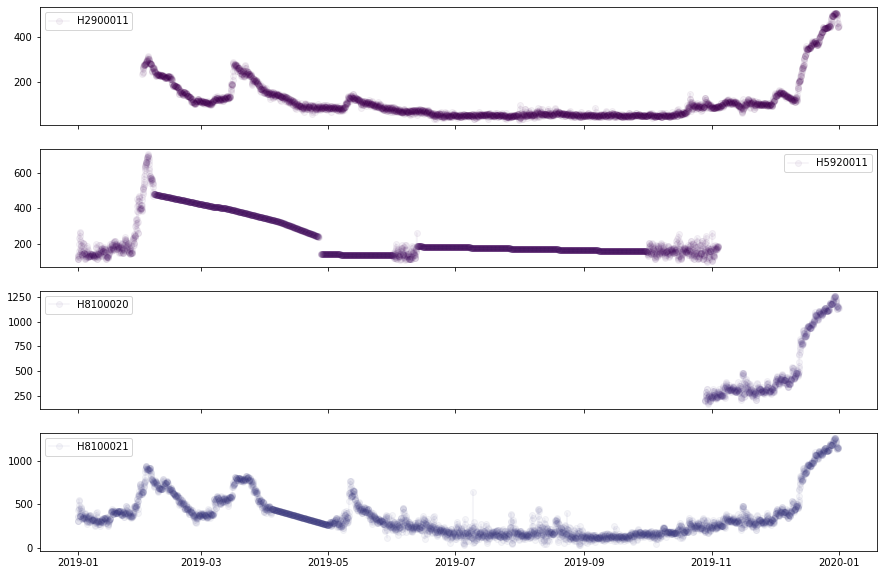

In [51]:
fig, axs = plt.subplots(len(stations_incomplet), 1, figsize = (15,10), sharex=True)
for i in range(len(stations_incomplet)):
    code = stations_incomplet[i]
    axs[i].plot(mesures["Date"], mesures[code], label = code, 
                color = cm.get_cmap("viridis")(tableau_stations.loc[i, "Distance amont"]/dist_aval), marker = "o", alpha = 0.05)
    axs[i].legend()

On va garder la dernière station à priori.

In [52]:
stations_complet.append(stations_incomplet[3])

In [53]:
stations_complet

['H0020010',
 'H0100010',
 'H0100020',
 'H0400010',
 'H0400020',
 'H0800011',
 'H0800012',
 'H0810010',
 'H1700010',
 'H1940020',
 'H3930020',
 'H4340020',
 'H5920014',
 'H8100021']

# Datasets avec les bonnes stations

In [54]:
mesures["Date"][list_debut]

NameError: name 'list_debut' is not defined

In [ ]:
mesures["Date"][list_fin]

In [ ]:
list_fin

In [ ]:
plt.plot(corr[4350:4410])

In [ ]:
station2 = tableau_stations[tableau_stations["Ordre"] == 5]["Code station"].values[0]
station2

In [ ]:
plt.plot(corr)